In [ ]:
#default_exp lightcurve
%load_ext autoreload
from nbdev.showdoc import show_doc

# Light Curve Generation
> Generate light curves from cells

A "light curve" is a table indexed by time, 't', in MJD with columns

- tw -- the cell width, initialized to be config.time_interval: when cells are combined
- n  -- number of photons
- e  -- relative exposure
- fit -- the fit object, containing info about the flux. This is usually a `PoissonRep` object



In [ ]:
#export
import numpy as np
import pylab as plt
import pandas as pd

In [ ]:
#export
from light_curves.loglike import (LogLike, GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable)

class _LightCurve(object):
    """ Apply likelihood fits to a set of cells
    
    parameters:
       - cells : a table with index t, columns  tw, n, e, w, S, B
       - min_exp : minimum fractional exposure allowed
       - rep_name : represention to use 

    Generates a DataTable with columns n, ep, fit
        
    """

    rep_class =  [GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable]
    rep_list =   'gauss gauss2d poisson poissontable'.split()

    def __init__(self, config, 
                all_cells, 
                source, 
                min_exp:  'minimum exposure factor'= 0.3,
                rep_name: 'likelihood rep name'='',
    
                ):
        """Apply fits to the likelihoods for a set of cells
        
 
        """

        self.source_name = source.name
 
        # select the set of cells
        cells = all_cells.query(f'e>{min_exp}').copy()
        
        # generate a list of LogLike objects for each
        cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
        if config.verbose>0:
            print(f'Loaded {len(cells)} / {len(all_cells)} cells with exposure >'\
                  f' {min_exp} for light curve analysis')
            print(f'first cell: {cells.iloc[0]}')

        # analyze using selected rep
        rep_name = rep_name or config.likelihood_rep
        
        if rep_name not in self.rep_list:
            raise Exception(f'Unrecognized rep: "{rep_name}", must be one of {self.rep_list}')
        repcl = self.rep_class[self.rep_list.index(rep_name)]

        if config.verbose>1:
            print(f'Fitting likelihoods with {rep_name} representation')
        
        # making output with reduced columns 
        self.ll_fits = cells['t tw n e'.split()].copy()
        self.ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)

    def __repr__(self):
        return f'{self.__class__.__name__}: source "{self.source_name}" fit with {len(self.ll_fits)} cells'


    @property
    def dataframe(self):
        """return the DataFrame
        """
        return self.ll_fits

In [ ]:
#export    

from light_curves.config import Config, Files, PointSource
from light_curves.cells import get_cells

def get_lightcurve(config, files, source, bin_edges=None):
    """Returns a lightcurve table for the source
    
    """
    def doit():
        cells = get_cells(config, files, source, bin_edges)
        lc = _LightCurve(config, cells, source).dataframe
        return lc
        
    if bin_edges is None:
        key = f'lightcurve_{source.name}'
        # use cache only for full data set
        if config.verbose>1: 
            print(f'using cache with key "{key}", exists: {key in files.cache}')
        return files.cache(key, doit)
    else:
        return doit()

In [ ]:
#collapse_hide
from light_curves.config import Config, Files, PointSource
from light_curves.cells import get_cells

def test_lc(bins=None):
    config = Config()
    files = Files()
    source = PointSource('Geminga')
    if not files.valid:
        return
    print(f'Loading cells with source {source.name} bins {bins} ')
    lc = get_lightcurve(config, files, source, bins)
    assert lc is not None
    print(f'LIght curve has {len(lc)} cells')
    c = lc.iloc[0]
    print(f'\nFirst cell fit: {c["fit"]}')
    return lc
test_lc().head()

Loading cells with source Geminga bins None 
using cache with key "lightcurve_Geminga", exists: True
LIght curve has 3873 cells

First cell fit: light_curves.loglike.PoissonRep: flux: 0.927[1+0.076-0.079], limit: 1.05, ts: 481.9


,t,n,e,tw,fit
0,54683.5,330,1.264560,1,light_curves.loglike.PoissonRep: flux: 0.927[1...
1,54684.5,348,1.216036,1,light_curves.loglike.PoissonRep: flux: 1.097[1...
2,54685.5,338,1.183077,1,light_curves.loglike.PoissonRep: flux: 1.146[1...
3,54686.5,378,1.407534,1,light_curves.loglike.PoissonRep: flux: 0.989[1...
4,54687.5,341,1.299294,1,light_curves.loglike.PoissonRep: flux: 0.975[1...


In [ ]:
# bin edges for 
edges = lc.t.values-lc.tw.values/2
test_bins = edges[:10:2 ]
test_lc(test_bins).head()

Loading cells with source Geminga bins [54683. 54685. 54687. 54689. 54691.] 
restored photons_Geminga from cache

	Selected 1313726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/d/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
restore exposure_Geminga from cache
2695715 entries, MJD 54683 - 58698
Loaded 4 / 4 cells with exposure > 0.3 for light curve analysis
first cell: t                                                      54684
tw                                                         2
e                                                   0.977511
n                                                        678
w          [244, 214, 174, 5, 246, 150, 187, 65, 91, 215,...
S                                   

,t,tw,n,e,fit
0,54684.0,2.0,678,0.977511,light_curves.loglike.PoissonRep: flux: 0.987[1...
1,54686.0,2.0,716,1.020863,light_curves.loglike.PoissonRep: flux: 1.037[1...
2,54688.0,2.0,699,1.041578,light_curves.loglike.PoissonRep: flux: 0.947[1...
3,54690.0,2.0,681,0.960047,light_curves.loglike.PoissonRep: flux: 1.016[1...


In [ ]:
cells = get_cells(config, files, source, test_bins)
cells

restored photons_Geminga from cache

	Selected 1313726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/d/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
restore exposure_Geminga from cache
2695715 entries, MJD 54683 - 58698


,t,tw,e,n,w,S,B
0,54684.0,2.0,0.977511,678,"[244, 214, 174, 5, 246, 150, 187, 65, 91, 215,...",451.057381,226.846442
1,54686.0,2.0,1.020863,716,"[138, 13, 107, 13, 195, 219, 247, 148, 245, 5,...",471.061763,236.907075
2,54688.0,2.0,1.041578,699,"[246, 185, 82, 163, 240, 182, 31, 200, 200, 14...",480.620292,241.714264
3,54690.0,2.0,0.960047,681,"[245, 13, 127, 201, 205, 185, 206, 54, 120, 48...",442.999090,222.793754


In [ ]:
#export
def flux_plot(config, lightcurve, ts_min=9,  title=None, ax=None, fignum=1,
              figsize=(12,4),
              step=False, 
              tzero:'time offset'=0,
              colors=('cornflowerblue','sandybrown', 'blue'), fmt=' ',
              **kwargs): 
    """Make a plot of flux vs. MJD
    
    - lightcurve 
    - ts_min -- threshold for ploting limit
    - colors -- tuple of colors for signal, limit
    - kwargs -- apply to the Axis object
    
    returns the Figure instance
    """
    kw=dict(yscale='linear',
            xlabel='MJD'+ f' - {tzero}' if tzero else '' ,
            ylabel='relative flux')
    kw.update(**kwargs)
    df=lightcurve
    rep = config.likelihood_rep
    if rep =='poisson':
        ts = df.fit.apply(lambda f: f.ts) 
        limit = ts<ts_min
        bar = df.loc[~limit,:]
        lim = df.loc[limit,:]
        allflux= np.select([~limit, limit], 
                        [df.fit.apply(lambda f: f.flux).values,
                         df.fit.apply(lambda f: f.limit).values],
                       )
        
    else: 
        bar=df; lim=[]

    fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)\
        if ax is not None else (ax.figure,ax)

    # the points with error bars
    t = bar.t.values-tzero
    tw = bar.tw.values 
    fluxmeas = allflux[~limit]
    upper = bar.fit.apply(lambda f: f.errors[1]).values
    lower = bar.fit.apply(lambda f: f.errors[0]).values
    error = np.array([upper-fluxmeas, fluxmeas-lower])

#     if rep=='poisson':
#         dy = [bar.errors.apply(lambda x: x[i]).clip(0,4) for i in range(2)]
#     elif rep==='gauss' or rep=='gauss2d':
#         dy = bar.sig_flux.clip(0,4)
#     else: assert False, f'Unrecognized likelihood rep: {rep}'   

    ax.errorbar(x=t, xerr=tw/2, y=fluxmeas, yerr=error, fmt=fmt, color=colors[0], )#'silver')

    if step:
        t = df.t.values-tzero
        xerr = df.tw.values/2; 
        x = np.append(t-xerr, [t[-1]+xerr[-1]]); 
        y = np.append(allflux, [allflux[-1]])
        ax.step(x, y, color=colors[2], where='post', )

    
    # now do the limits (only for poisson rep)
    error_size=2
    if len(lim)>0:
        t = lim.t-tzero
        tw = lim.tw 

        y = allflux[limit]
        yerr=0.2*(1 if kw['yscale']=='linear' else y)
        ax.errorbar(x=t, y=y, xerr=tw/2,
                yerr=yerr,  color=colors[1], 
                uplims=True, ls='', lw=error_size, capsize=3*error_size, capthick=0,
               )

    #ax.axhline(1., color='grey')
    ax.set(**kw)
    ax.set_title(title) # or f'{source_name}, rep {self.rep}')
    ax.grid(alpha=0.5)
    return fig

In [ ]:
show_doc(flux_plot)

<h4 id="flux_plot" class="doc_header"><code>flux_plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>flux_plot</code>(**`config`**, **`lightcurve`**, **`ts_min`**=*`9`*, **`title`**=*`None`*, **`ax`**=*`None`*, **`fignum`**=*`1`*, **`figsize`**=*`(12, 4)`*, **`colors`**=*`('cornflowerblue', 'sandybrown')`*, **`fmt`**=*`' '`*, **\*\*`kwargs`**)

Make a plot of flux vs. MJD

- lightcurve 
- ts_min -- threshold for ploting limit
- colors -- tuple of colors for signal, limit
- kwargs -- apply to the Axis object

returns the Figure instance

Example plot-- the first 100 days of Fermi data for Geminga

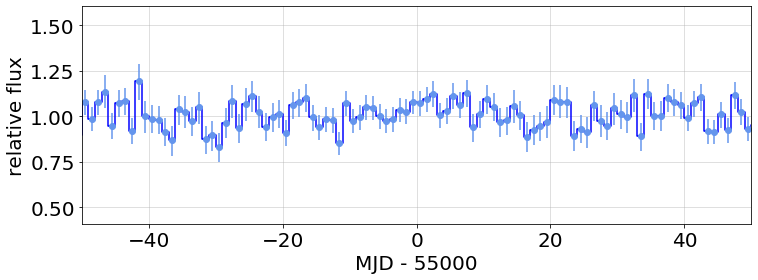

In [ ]:
#collapse_hide
if lc is not None:
    plt.rc('font', size=20)
    fig, ax = plt.subplots(figsize=(12,4))
    flux_plot(config, lc, fmt='o', ax=ax, xlim=(-50,50), step=True, tzero=55000)

    
    

And forcing upper limits

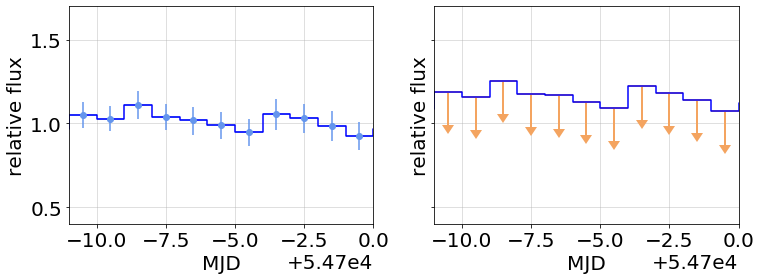

In [ ]:
#collapse_hide
if lc is not None:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
    flux_plot(config, lc, ax=ax1, fmt='o', xlim=(54689, 54700),  step=True)
    flux_plot(config, lc, ax=ax2, fmt='o', xlim=(54689, 54700), ts_min=1000, step=True)

In [ ]:
!date

Tue Dec 15 09:25:12 PST 2020


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_load_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 07_cells.ipynb.
Converted 09_poisson.ipynb.
Converted 10_loglike.ipynb.
Converted 11_lightcurve.ipynb.
Converted 12_instructions.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Tue Dec 15 09:44:04 PST 2020
